# 0. Context

L’entreprise pharmaceutique HumanForYou, située en Inde, emploie environ 4 000 personnes mais doit faire face à un taux de turn-over annuel de 15%, impactant son fonctionnement de plusieurs manières :

- Retards de projets nuisibles à la réputation de l’entreprise auprès des clients et partenaires.
- Charge importante sur les ressources humaines, nécessitant un service conséquent pour recruter de nouveaux talents.
- Perte de productivité en raison du temps nécessaire à la formation et à l’intégration des nouveaux employés.
- L’objectif est de comprendre les facteurs clés influençant ce taux de turn-over et de proposer des modèles prédictifs et des stratégies concrètes pour réduire ce phénomène.

les etapes du projet : Données brutes > Données structurés (Catégorielle & Numérique) > input > Deeplearning / AI > produit (^y)

# I. Environement setup

In [99]:
# Import necessary libraries
import matplotlib.pyplot as plt
import math
import numpy as np
import nbformat
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from sklearn import datasets, feature_selection, linear_model, metrics, model_selection, tree
import warnings

warnings.filterwarnings('ignore')

# II. Data loading

In [2]:
# data path
csv_path = "./csv/"

# Load datasets
in_time = pd.read_csv(csv_path + "in_time.csv")
out_time = pd.read_csv(csv_path + "out_time.csv")
general_data = pd.read_csv(csv_path + "general_data.csv")
manager_survey_data = pd.read_csv(csv_path + "manager_survey_data.csv")
employee_survey_data = pd.read_csv(csv_path + "employee_survey_data.csv")

# III. Data mixing

In [3]:
# Time mixing
total_time = pd.concat([in_time, out_time], ignore_index=True)
total_time = total_time.replace(np.nan, 0)
total_time.iloc[:, 1:] = total_time.iloc[:, 1:].apply(pd.to_datetime, errors='coerce')
total_time = total_time.diff(periods=4410, axis=0)
total_time = total_time.iloc[4410:]
total_time.reset_index(inplace=True)
total_time.drop(
    columns=[
            'Unnamed: 0', '2015-01-01', '2015-01-14','2015-01-26','2015-03-05',
            '2015-05-01','2015-07-17','2015-09-17','2015-10-02',
            '2015-11-09','2015-11-10','2015-11-11','2015-12-25', 'index'
            ],
    axis=1,
    inplace=True
)
total_time = total_time.replace(pd.NaT, pd.Timedelta(0))
total_time['Mean Time']=total_time.mean(axis=1)
total_time['hrs']=total_time['Mean Time'] / np.timedelta64(1, 'h')
total_time.reset_index(inplace=True)
total_time.drop(total_time.columns.difference(['index','hrs']), axis=1, inplace=True)
total_time.rename(columns={'index': 'EmployeeID'}, inplace=True)

total_time.head()

,EmployeeID,hrs
0,0,6.870229
1,1,7.315971
2,2,6.816081
3,3,6.789215
4,4,7.877561


In [4]:
# Create global dataframe
global_data = pd.merge(general_data, total_time, on='EmployeeID', how='inner')
global_data = pd.merge(global_data, manager_survey_data, on='EmployeeID', how='inner')
global_data = pd.merge(global_data, employee_survey_data, on='EmployeeID', how='inner')

global_data.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,hrs,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,6,1,0,0,7.315971,3,3,3.0,4.0,2.0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,3,5,1,4,6.816081,2,4,3.0,2.0,4.0
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,2,5,0,3,6.789215,3,3,2.0,2.0,1.0
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,5,8,7,5,7.877561,2,3,4.0,4.0,3.0
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,2,6,0,4,10.275802,3,3,4.0,1.0,3.0


# IV. Remove unusable data

In [5]:
# Delete unique value column
for col in global_data.columns:
    if len(global_data[col].unique()) == 1:
        global_data.drop(columns=[col], axis=1, inplace=True)
        print("Deleted : " + col + " (Only one value)")

# Delete Ethical column
global_data.drop(columns=['Age', 'EmployeeID', 'Gender', 'MaritalStatus'], axis=1, inplace=True)

global_data.head()

Deleted : EmployeeCount (Only one value)
Deleted : Over18 (Only one value)
Deleted : StandardHours (Only one value)


,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,JobLevel,JobRole,MonthlyIncome,NumCompaniesWorked,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,hrs,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,No,Travel_Rarely,Sales,6,2,Life Sciences,1,Healthcare Representative,131160,1.0,...,6,1,0,0,7.315971,3,3,3.0,4.0,2.0
1,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,Research Scientist,41890,0.0,...,3,5,1,4,6.816081,2,4,3.0,2.0,4.0
2,No,Travel_Frequently,Research & Development,17,4,Other,4,Sales Executive,193280,1.0,...,2,5,0,3,6.789215,3,3,2.0,2.0,1.0
3,No,Non-Travel,Research & Development,2,5,Life Sciences,3,Human Resources,83210,3.0,...,5,8,7,5,7.877561,2,3,4.0,4.0,3.0
4,No,Travel_Rarely,Research & Development,10,1,Medical,1,Sales Executive,23420,4.0,...,2,6,0,4,10.275802,3,3,4.0,1.0,3.0


# V. Change column type for categorical data

In [6]:
global_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4409 entries, 0 to 4408
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Attrition                4409 non-null   object 
 1   BusinessTravel           4409 non-null   object 
 2   Department               4409 non-null   object 
 3   DistanceFromHome         4409 non-null   int64  
 4   Education                4409 non-null   int64  
 5   EducationField           4409 non-null   object 
 6   JobLevel                 4409 non-null   int64  
 7   JobRole                  4409 non-null   object 
 8   MonthlyIncome            4409 non-null   int64  
 9   NumCompaniesWorked       4390 non-null   float64
 10  PercentSalaryHike        4409 non-null   int64  
 11  StockOptionLevel         4409 non-null   int64  
 12  TotalWorkingYears        4401 non-null   float64
 13  TrainingTimesLastYear    4409 non-null   int64  
 14  YearsAtCompany          

In [7]:
global_data['Education'] = global_data['Education'].astype('object')
global_data['EnvironmentSatisfaction'] = global_data['EnvironmentSatisfaction'].astype('object')
global_data['JobInvolvement'] = global_data['JobInvolvement'].astype('object')
global_data['JobSatisfaction'] = global_data['JobSatisfaction'].astype('object')
global_data['PerformanceRating'] = global_data['PerformanceRating'].astype('object')
global_data['JobLevel'] = global_data['JobLevel'].astype('object')
global_data['WorkLifeBalance'] = global_data['WorkLifeBalance'].astype('object')

global_data.head()

,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,JobLevel,JobRole,MonthlyIncome,NumCompaniesWorked,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,hrs,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,No,Travel_Rarely,Sales,6,2,Life Sciences,1,Healthcare Representative,131160,1.0,...,6,1,0,0,7.315971,3,3,3.0,4.0,2.0
1,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,Research Scientist,41890,0.0,...,3,5,1,4,6.816081,2,4,3.0,2.0,4.0
2,No,Travel_Frequently,Research & Development,17,4,Other,4,Sales Executive,193280,1.0,...,2,5,0,3,6.789215,3,3,2.0,2.0,1.0
3,No,Non-Travel,Research & Development,2,5,Life Sciences,3,Human Resources,83210,3.0,...,5,8,7,5,7.877561,2,3,4.0,4.0,3.0
4,No,Travel_Rarely,Research & Development,10,1,Medical,1,Sales Executive,23420,4.0,...,2,6,0,4,10.275802,3,3,4.0,1.0,3.0


# VI. Replace data

In [8]:
# Replace numerical data
for col in global_data.columns:
    if global_data[col].isna().values.any():
        global_data[col].fillna(global_data[col].median(), inplace=True)

# Replace categorical data
global_data['Education'].replace({1: 'BAC', 2: 'BAC+2', 3: 'BAC+3', 4: 'BAC+5', 5: 'Doctorat'}, inplace=True)
global_data['JobInvolvement'].replace({1: 'Faible', 2: 'Moyenne', 3: 'Importante', 4: 'Très importante'}, inplace=True)
global_data['PerformanceRating'].replace({1: 'Faible', 2: 'Bon', 3: 'Excellent', 4: 'Au delà des attentes'}, inplace=True)
global_data['EnvironmentSatisfaction'].replace({1: 'Faible', 2: 'Moyen', 3: 'Élevé', 4: 'Très élevé'}, inplace=True)
global_data['JobSatisfaction'].replace({1: 'Faible', 2: 'Moyen', 3: 'Élevé', 4: 'Très élevé'}, inplace=True)
global_data['WorkLifeBalance'].replace({1: 'Mauvais', 2: 'Satisfaisant', 3: 'Très satisfaisant', 4: 'Excellent'}, inplace=True)

global_data.head()

,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,JobLevel,JobRole,MonthlyIncome,NumCompaniesWorked,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,hrs,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,No,Travel_Rarely,Sales,6,BAC+2,Life Sciences,1,Healthcare Representative,131160,1.0,...,6,1,0,0,7.315971,Importante,Excellent,Élevé,Très élevé,Satisfaisant
1,Yes,Travel_Frequently,Research & Development,10,BAC,Life Sciences,1,Research Scientist,41890,0.0,...,3,5,1,4,6.816081,Moyenne,Au delà des attentes,Élevé,Moyen,Excellent
2,No,Travel_Frequently,Research & Development,17,BAC+5,Other,4,Sales Executive,193280,1.0,...,2,5,0,3,6.789215,Importante,Excellent,Moyen,Moyen,Mauvais
3,No,Non-Travel,Research & Development,2,Doctorat,Life Sciences,3,Human Resources,83210,3.0,...,5,8,7,5,7.877561,Moyenne,Excellent,Très élevé,Très élevé,Très satisfaisant
4,No,Travel_Rarely,Research & Development,10,BAC,Medical,1,Sales Executive,23420,4.0,...,2,6,0,4,10.275802,Importante,Excellent,Très élevé,Faible,Très satisfaisant


# VII. Preparing data for the model

In [9]:
# Get categorical column
categorical_column_data = global_data.select_dtypes(include='object').drop(columns=['Attrition'])
categorical_column_name = list(categorical_column_data.columns.values)
categorical_column_name

['BusinessTravel',
 'Department',
 'Education',
 'EducationField',
 'JobLevel',
 'JobRole',
 'JobInvolvement',
 'PerformanceRating',
 'EnvironmentSatisfaction',
 'JobSatisfaction',
 'WorkLifeBalance']

In [10]:
# Replace categorical data with numerical data
global_data_dummy = pd.get_dummies(global_data, columns=categorical_column_name)
global_data_dummy['Attrition'] = global_data_dummy['Attrition'].map({'Yes': 1, 'No': 0})

global_data_dummy.head()

,Attrition,DistanceFromHome,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,...,EnvironmentSatisfaction_Très élevé,EnvironmentSatisfaction_Élevé,JobSatisfaction_Faible,JobSatisfaction_Moyen,JobSatisfaction_Très élevé,JobSatisfaction_Élevé,WorkLifeBalance_Excellent,WorkLifeBalance_Mauvais,WorkLifeBalance_Satisfaisant,WorkLifeBalance_Très satisfaisant
0,0,6,131160,1.0,11,0,1.0,6,1,0,...,False,True,False,False,True,False,False,False,True,False
1,1,10,41890,0.0,23,1,6.0,3,5,1,...,False,True,False,True,False,False,True,False,False,False
2,0,17,193280,1.0,15,3,5.0,2,5,0,...,False,False,False,True,False,False,False,True,False,False
3,0,2,83210,3.0,11,3,13.0,5,8,7,...,True,False,False,False,True,False,False,False,False,True
4,0,10,23420,4.0,12,2,9.0,2,6,0,...,True,False,True,False,False,False,False,False,False,True


Text(0.5, 1.0, 'Correlation Heatmap')

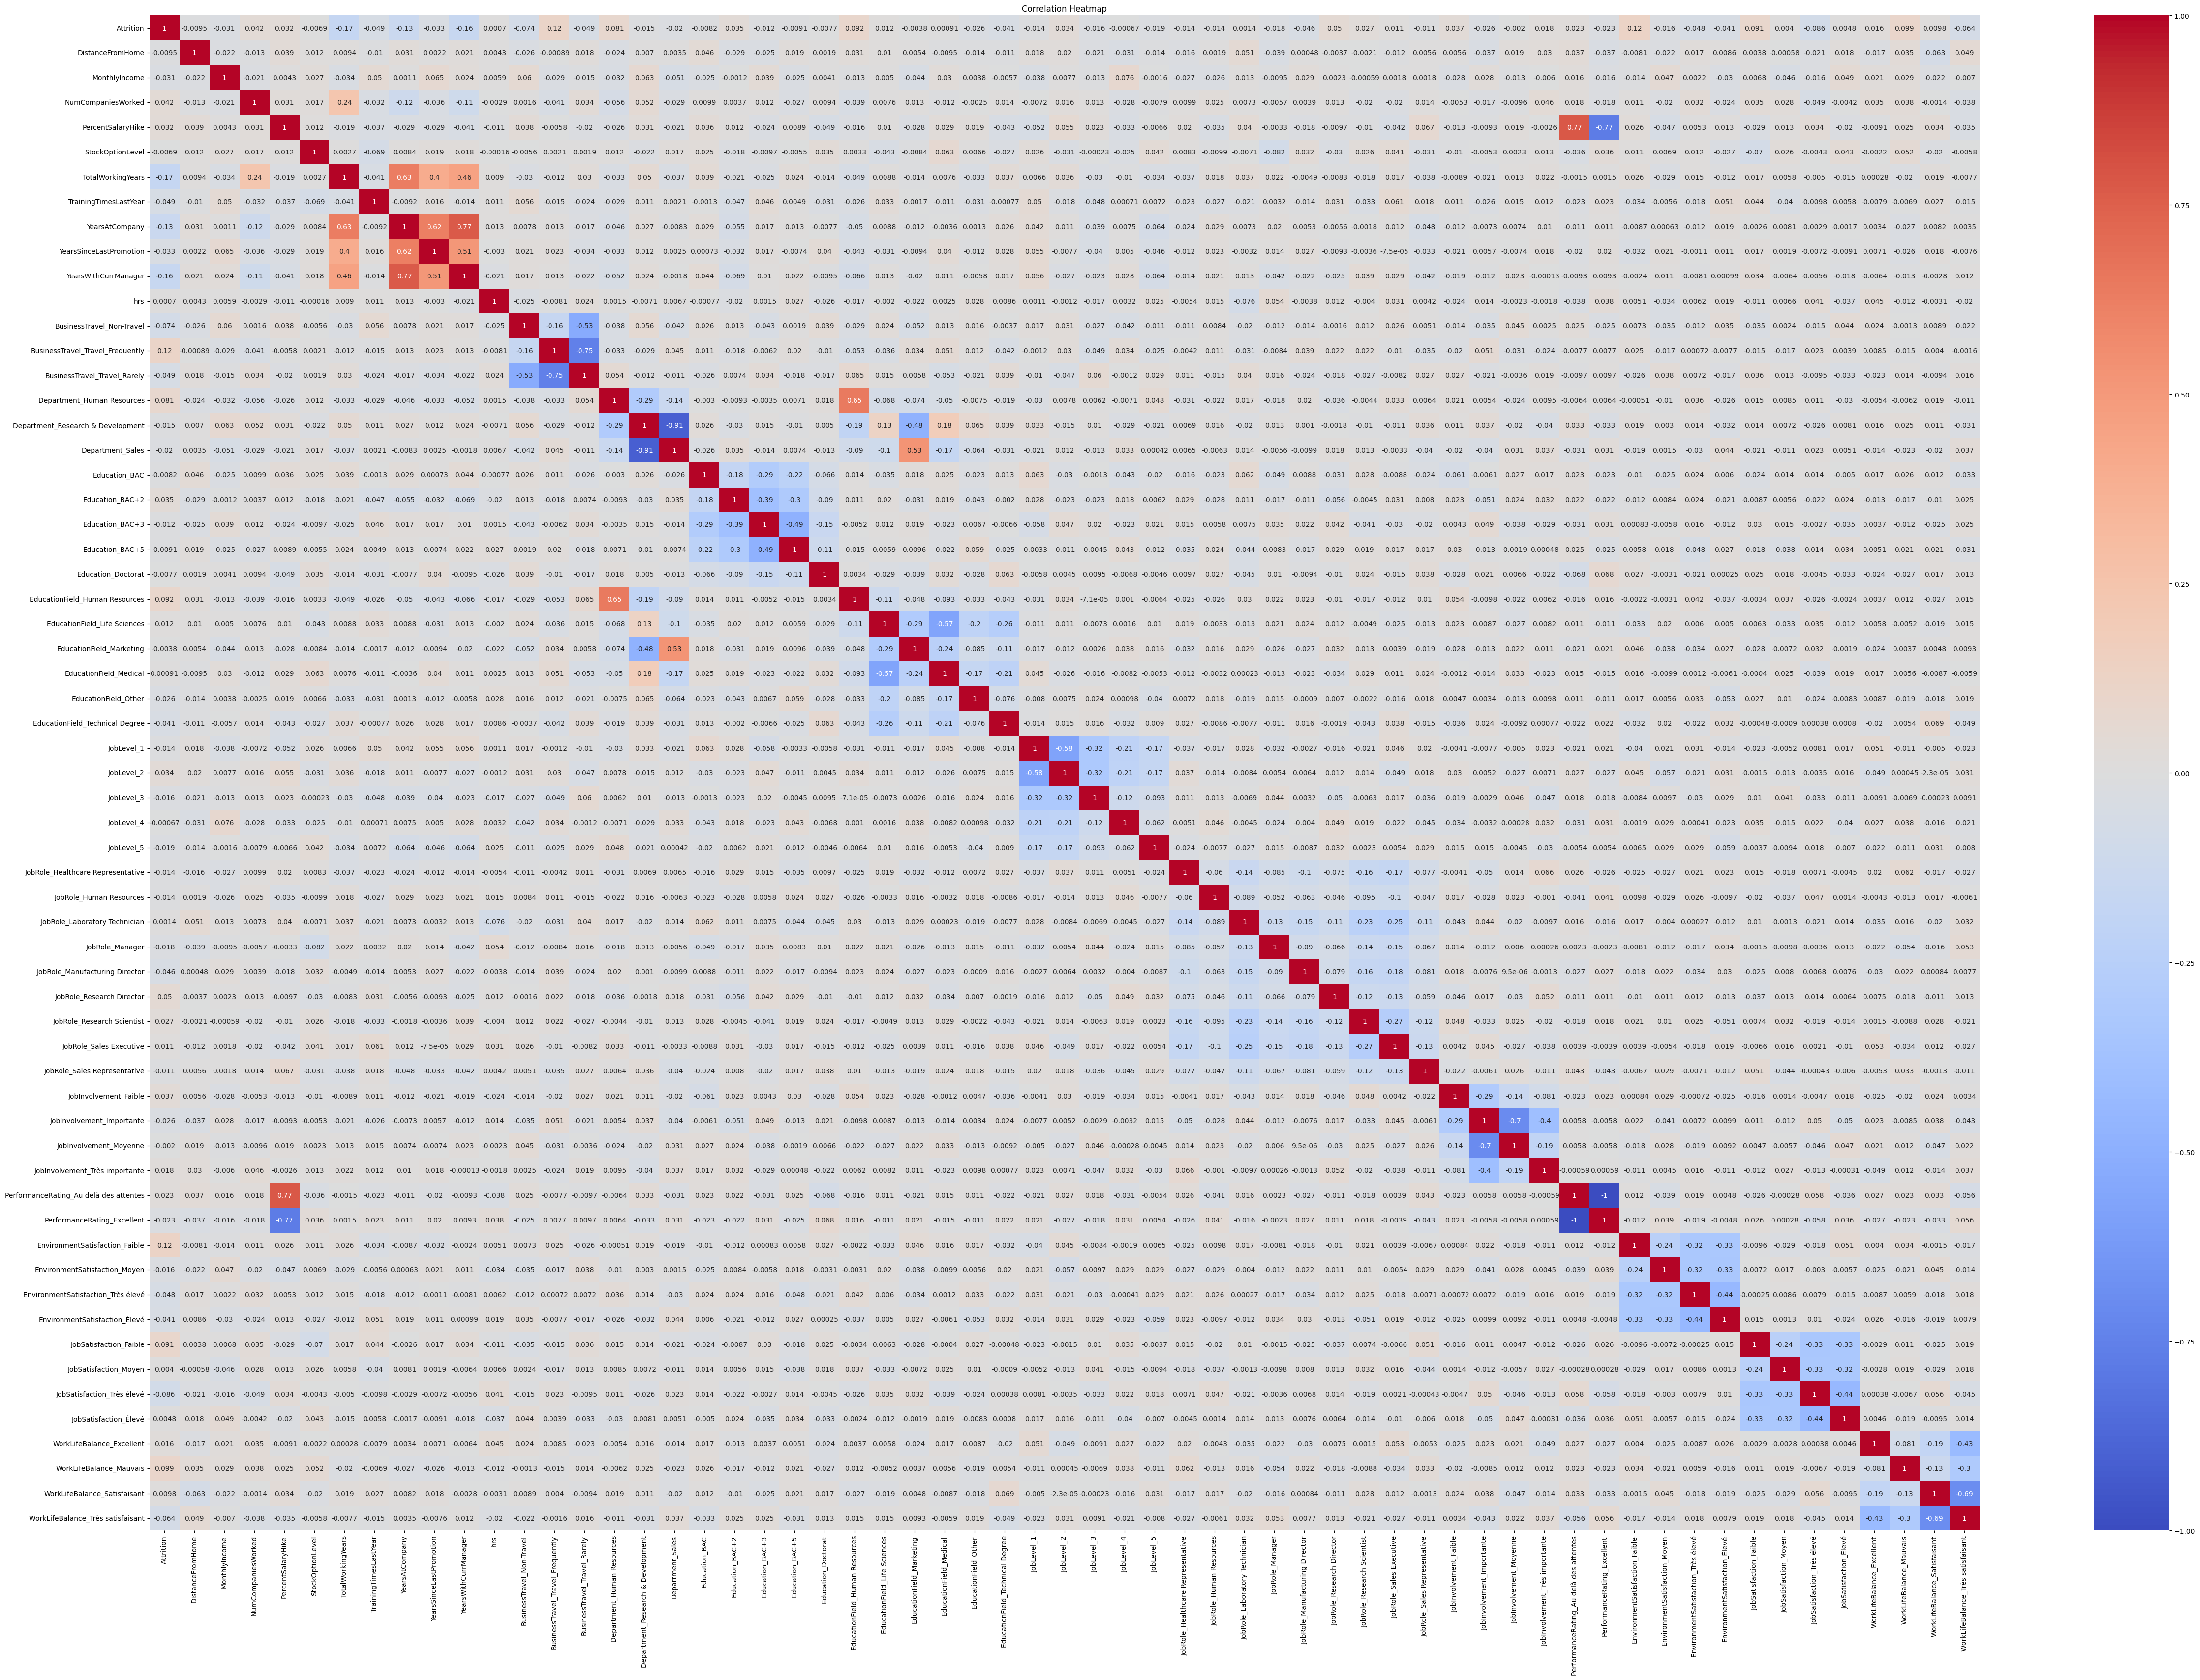

In [18]:
# Correlation matrix
plt.figure(figsize=(60, 40))
sns.heatmap(global_data_dummy.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')

In [55]:
# Split train data with test data
X = global_data_dummy.drop('Attrition', axis=1)
y = global_data_dummy['Attrition']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)


# VIII. Model application on training values

Model Accuracy:  0.7011624610150269
MSE: 0.29883753898497306
ROC_AUC Score:  0.7069272667704153


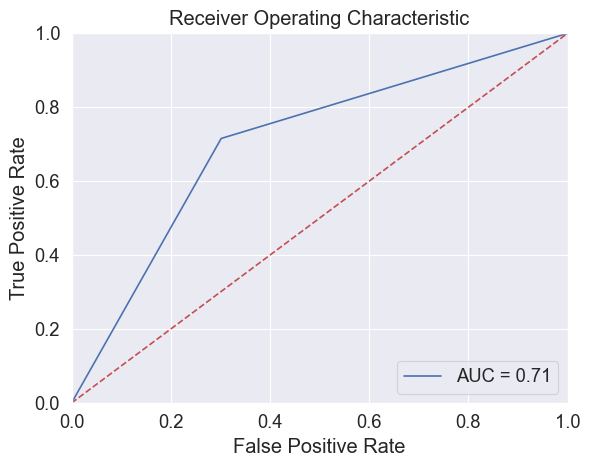

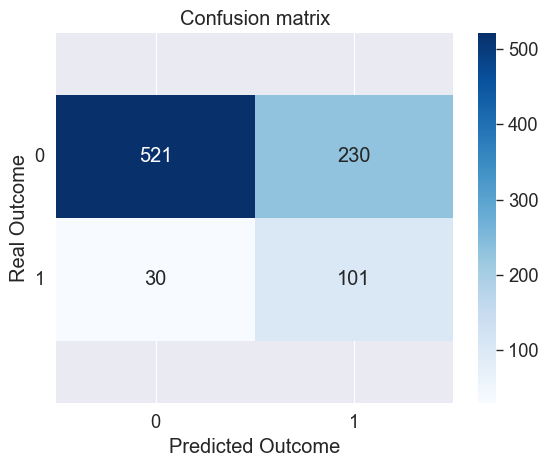

In [93]:
# Logistic regression on training values
model = linear_model.LogisticRegression(random_state=42, solver='liblinear', penalty='l1', class_weight="balanced")
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)

accuracy = metrics.accuracy_score(y_train, y_pred_train)
mae = metrics.mean_absolute_error(y_train, y_pred_train)
mse = metrics.mean_squared_error(y_train, y_pred_train)
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_train)
lrroc_auc = metrics.auc(fpr, tpr)

print('Model Accuracy: ', accuracy)
print("MSE:", mse)
print('ROC_AUC Score: ', lrroc_auc)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % lrroc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

sns.set_theme(context="paper", font_scale=1.5)
lrcm = metrics.confusion_matrix(y_test, y_pred_test)
ax = heatmap = sns.heatmap(lrcm, cmap="Blues", annot= True,fmt=".0f")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion matrix')
plt.ylabel('Real Outcome')
plt.xlabel('Predicted Outcome')
plt.yticks(rotation=0)
plt.show()

In [86]:
# Linear regression on training values
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)

mse = metrics.mean_absolute_error(y_train, y_pred_train)
mse = metrics.mean_squared_error(y_train, y_pred_train)
r2 = metrics.r2_score(y_train, y_pred_train)

print("MSE :", mse)
print("R² :", r2)

MSE : 0.11808318429512224
R² : 0.14060891140705534


In [87]:
# Decision tree on training values
model = tree.DecisionTreeRegressor(max_depth=4, random_state=42)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)

mse = metrics.mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mse)

print("MSE :", mse)
print("RMSE :", rmse)

MSE : 0.11462843044623898
RMSE : 0.3385682064905667


# IX. Model application on test values

Model Accuracy:  0.7052154195011338
MSE: 0.2947845804988662
ROC_AUC Score:  0.7323670220875982


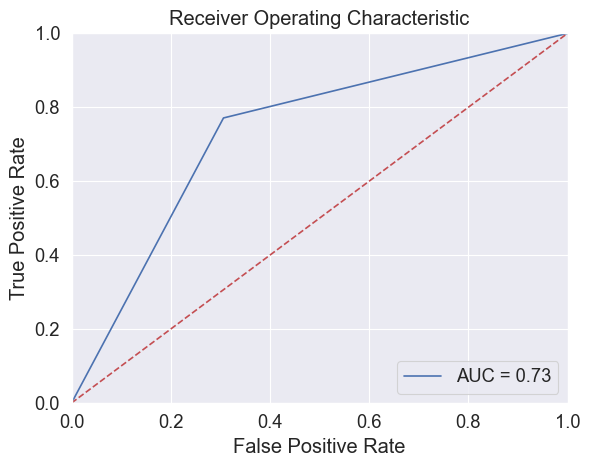

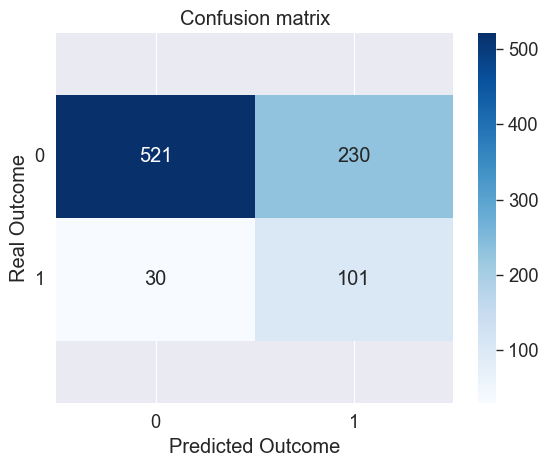

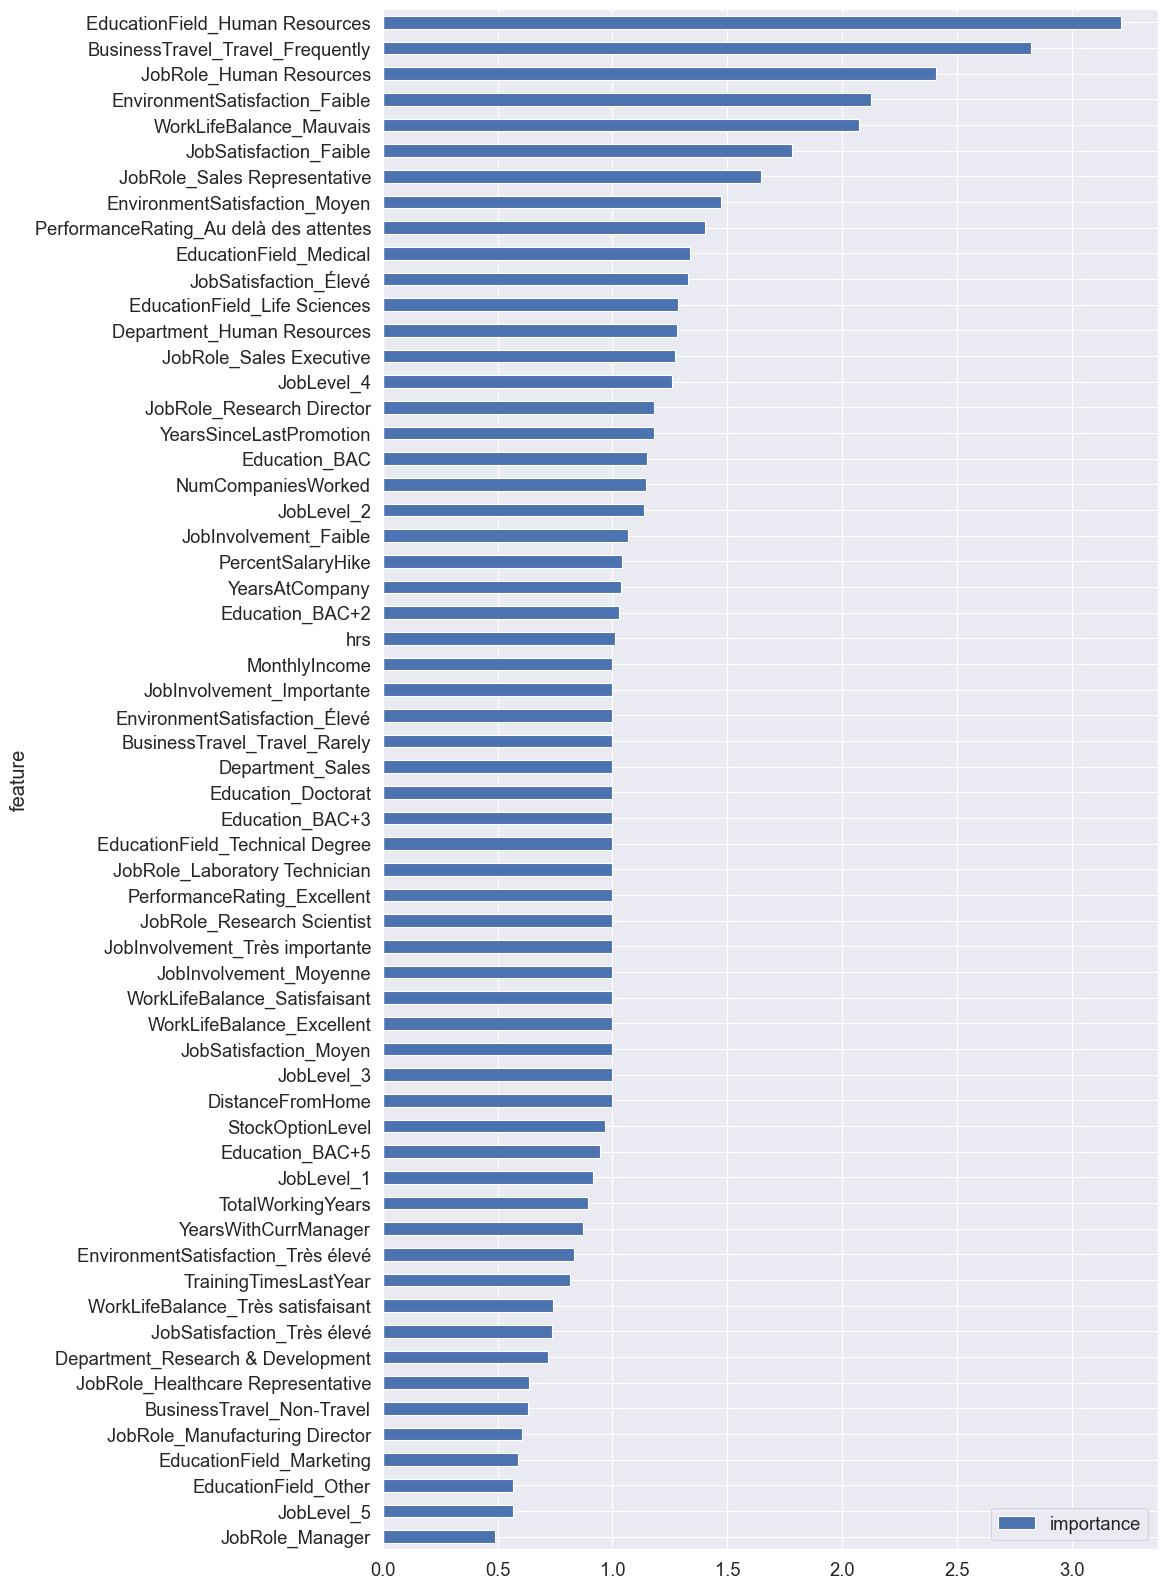

In [109]:
# Logistic regression on test values
model = linear_model.LogisticRegression(random_state=42, solver='liblinear', penalty='l1', class_weight="balanced")
model.fit(X_test, y_test)

y_pred_test = model.predict(X_test)

accuracy = metrics.accuracy_score(y_test, y_pred_test)
mae = metrics.mean_absolute_error(y_test, y_pred_test)
mse = metrics.mean_squared_error(y_test, y_pred_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_test)
lrroc_auc = metrics.auc(fpr, tpr)

print('Model Accuracy: ', accuracy)
print("MSE:", mse)
print('ROC_AUC Score: ', lrroc_auc)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % lrroc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

sns.set_theme(context="paper", font_scale=1.5)
lrcm = metrics.confusion_matrix(y_test, y_pred_test)
ax = heatmap = sns.heatmap(lrcm, cmap="Blues", annot= True,fmt=".0f")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion matrix')
plt.ylabel('Real Outcome')
plt.xlabel('Predicted Outcome')
plt.yticks(rotation=0)
plt.show()

feature_names = np.array(X.columns)
feature_importance = pd.DataFrame(feature_names, columns = ["feature"])
feature_importance["importance"] = pow(math.e, model.coef_[0])
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=True)
feature_importance.plot.barh(x='feature', y='importance', figsize=(10, 20))
plt.show()

In [79]:
# Linear regression on test values
model = linear_model.LinearRegression()
model.fit(X_test, y_test)

y_pred_test = model.predict(X_test)

mse = metrics.mean_absolute_error(y_test, y_pred_test)
mse = metrics.mean_squared_error(y_test, y_pred_test)
r2 = metrics.r2_score(y_test, y_pred_test)

print("MSE :", mse)
print("R² :", r2)

MSE : 0.10800316914935511
R² : 0.14599102105749173


In [80]:
# Decision tree on test values
model = tree.DecisionTreeRegressor(max_depth=4, random_state=42)
model.fit(X_test, y_test)

y_pred_test = model.predict(X_test)

mse = metrics.mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)

print("MSE :", mse)
print("RMSE :", rmse)

MSE : 0.09380239759458754
RMSE : 0.30627177080917456
